# Basic Network

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../src/")
from collections import OrderedDict
import cellbell

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import utils
from models import SimpleDense

from sklearn.model_selection import train_test_split

Using Theano backend.
Using gpu device 0: GeForce GT 630M (CNMeM is disabled, cuDNN not available)


## Data

In [3]:
data_file = "../data/processed/stacking-data.h5"
df = pd.read_hdf(data_file, "data")

## Model

In [4]:
SimpleDense(1, 4).model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 1, 10)         540         embedding_input_1[0][0]          
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 10)            0           embedding_1[0][0]                
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 10)            0           flatten_1[0][0]                  
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 10)            110         activation_1[0][0]               
___________________________________________________________________________________________

## Training

Creating one model per score (*peak week*, *onset week*, etc.)

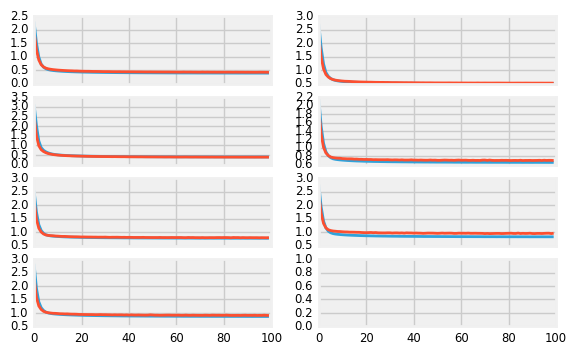

In [5]:
%%ding

scores = df.columns.levels[0]

models = OrderedDict()

f, axes = plt.subplots(4, 2, sharex=True)

for index, score in enumerate(scores):
    X = df[score].index.get_level_values("analysis_time_season_week").values
    y = df[score].as_matrix()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234)
    
    models[score] = SimpleDense(1, y.shape[1])
    # Using test split for validation as of now
    history = models[score].fit(X_train, y_train, nb_epoch=100, validation_data=(X_test, y_test), verbose=0)
    
    idx = int(np.floor(index / 2))
    idy = index % 2
    axes[idx, idy].plot(history.history["loss"], label="loss")
    axes[idx, idy].plot(history.history["val_loss"], label="validation loss")
plt.show()

## Score predictions

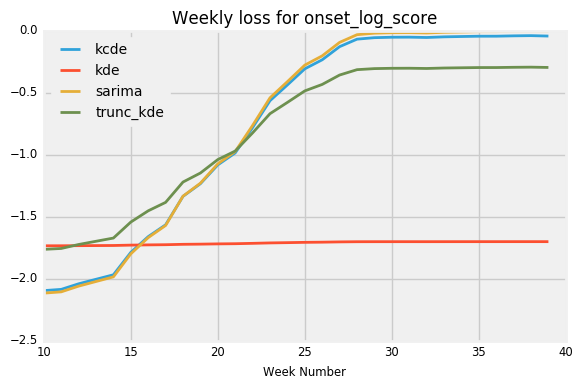

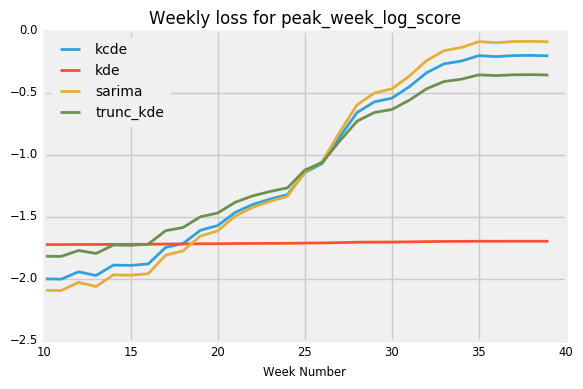

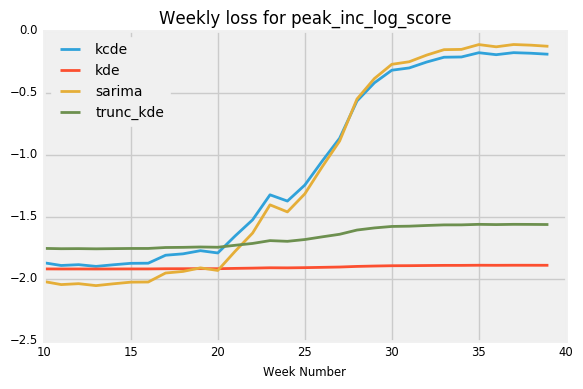

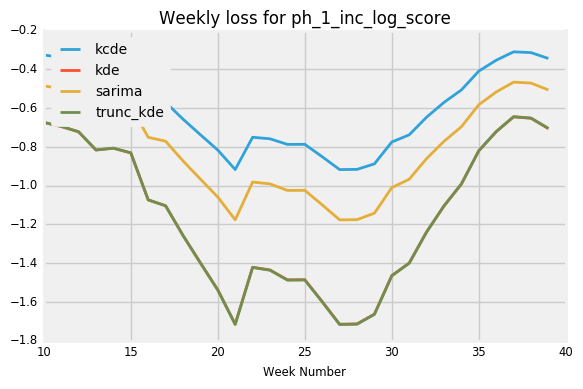

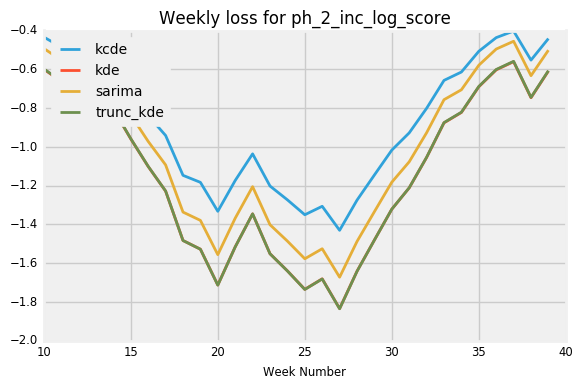

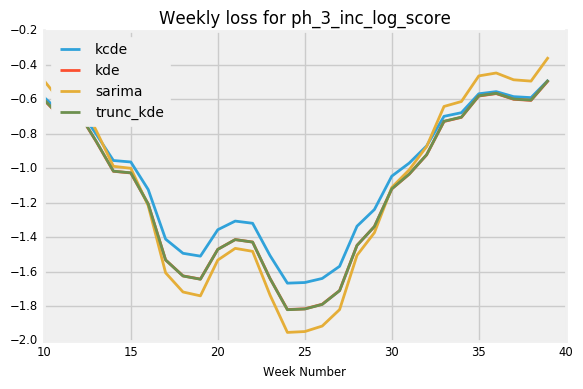

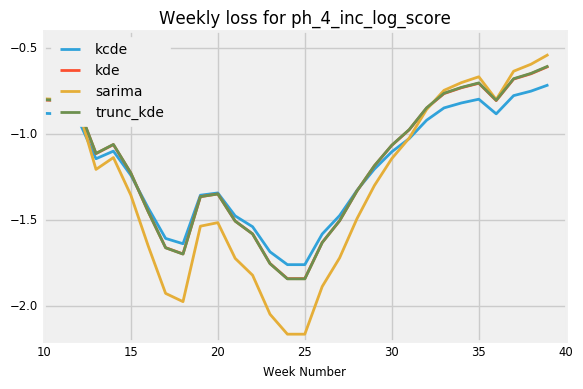

In [6]:
for score, model in models.items():
    weeks = np.arange(10, 40) # Only these weeks are available
    weights = model.predict(weeks)

    for idx, label in enumerate(df["onset_log_score"].columns):
        plt.plot(weeks, weights[:, idx], label=label)
    plt.legend(loc="upper left")
    plt.xlabel("Week Number")
    plt.title("Weekly loss for " + score)
    plt.show()

## Score to weights

Using softmax with variable temperature factor

Increase beta for harder weight preferences

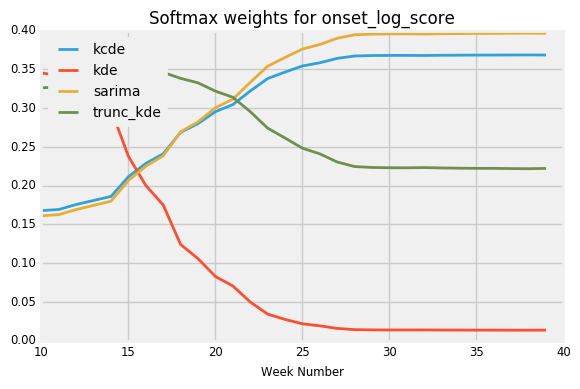

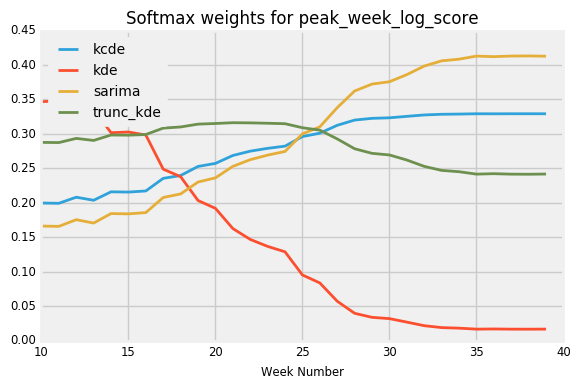

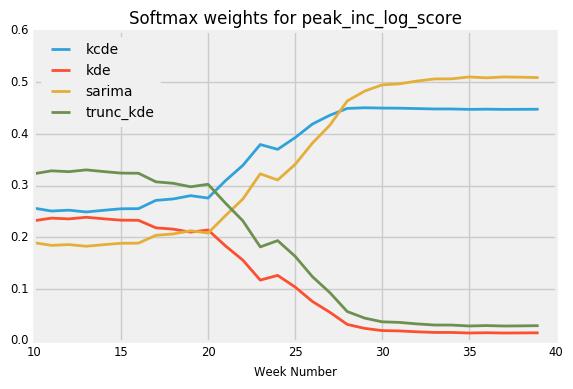

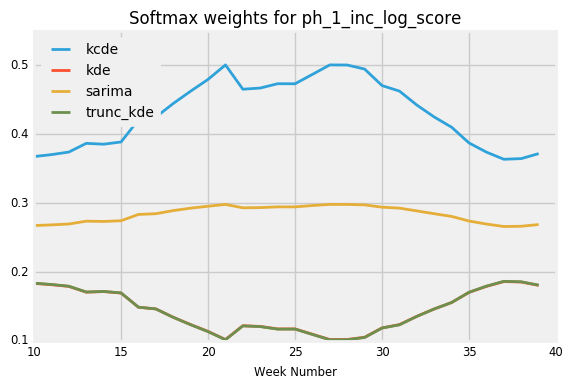

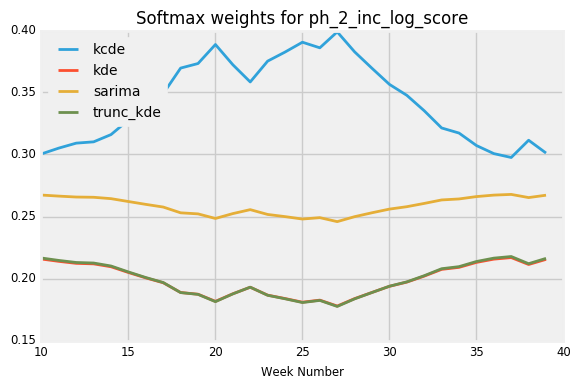

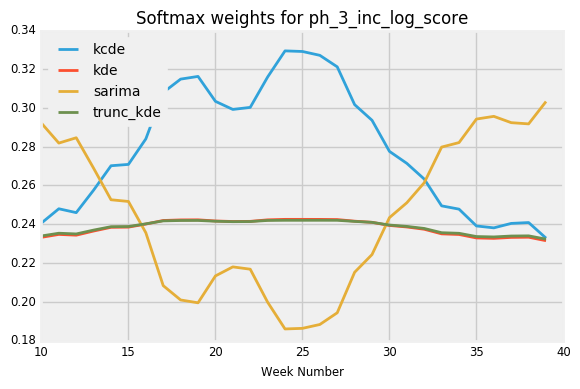

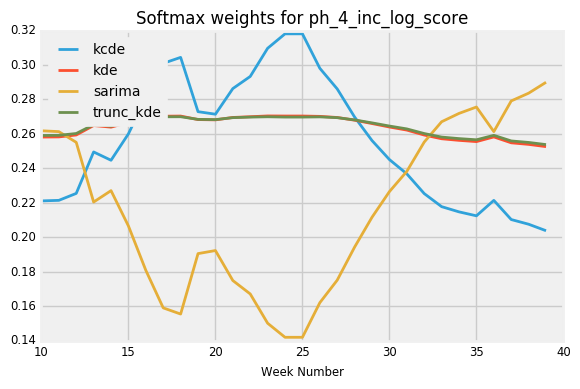

In [7]:
beta = 2

for score, model in models.items():
    weeks = np.arange(10, 40) # Only these weeks are available
    weights = np.exp(beta * model.predict(weeks))
    
    weights = weights / weights.sum(axis=1, keepdims=True)

    for idx, label in enumerate(df["onset_log_score"].columns):
        plt.plot(weeks, weights[:, idx], label=label)
    plt.legend(loc="upper left")
    plt.xlabel("Week Number")
    plt.title("Softmax weights for " + score)
    plt.show()